# 2D 2 comp GMM

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import multivariate_normal
from scipy.stats import norm
import corner as corner

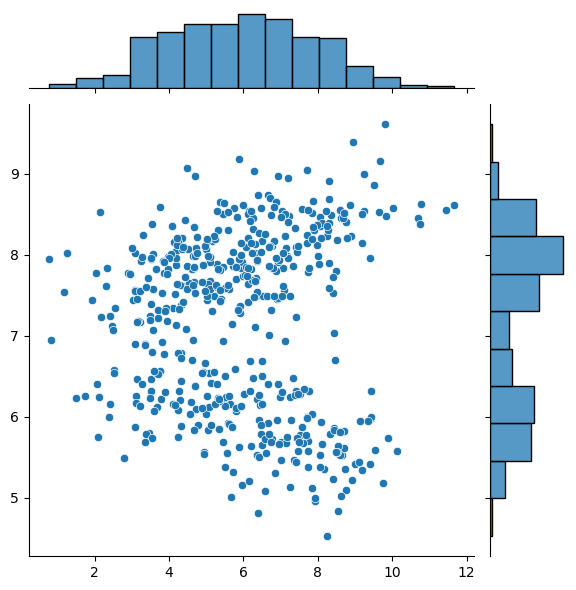

In [20]:
#Sets the seed
set_seed = True
if set_seed:
    np.random.seed(923114)

#Creates a covariance matrix with given standard deviations and correlation
def CorrToCov(σ, corr):
    R = np.matrix([[1, corr], [corr, 1]])
    D = np.matrix(np.diag(σ))
    S = D*R*D.T
    return S

#Generating the data for the first component
N0 = 300
μ0 = [6, 8]
σ0 = [2, 0.5]
corr0 = 0.5
Σ0 = CorrToCov(σ0, corr0)
data0 = multivariate_normal.rvs(size=N0, mean=μ0, cov=Σ0)

#Similarly for the second component
N1 = 200
μ1 = [6, 6]
σ1 = [2, 0.5]
corr1 = -0.5
Σ1 = CorrToCov(σ1, corr1)
data1 = multivariate_normal.rvs(size=N1, mean=μ1, cov=Σ1)

weight = N1/(N0+N1)

#Joining both components then plotting
data = np.vstack([data0, data1])
ax = sns.jointplot(x=data[:,0], y=data[:,1])

In [19]:
#Cholesky lower triangular matrix
def CholeskyLTM(lem):
    L = np.matrix([[np.exp(lem[0]), 0], [lem[1], np.exp(lem[2])]])
    Σ = L*L.T
    return Σ

#Esnuring the covariance matrix is positive semi-definite
def model(x, p):
    
    lem0 = p[2:5]
    Σ0 = CholeskyLTM(lem0)
    
    lem1 = p[7:10]
    Σ1 = CholeskyLTM(lem1)
    
    return p[:2], Σ0, p[5:7], Σ1, p[10]

def inverseCholeskyLTM(cov):
    lem0 = 0.5*np.log(cov[0, 0])
    lem1 = cov[0, 1]/np.exp(lem0)
    lem2 = 0.5*np.log(cov[1, 1]-lem1**2)
    return [lem0, lem1, lem2]

#Defining the log likelihood
def log_likelihood(p, x, prior_check=1):
    μ0, Σ0, μ1, Σ1, weight = model(x, p)
    
    logl0 = multivariate_normal.logpdf(x, mean=μ0, cov=Σ0) + np.log(1-weight)
    logl1 = multivariate_normal.logpdf(x, mean=μ1, cov=Σ1) + np.log(weight)
    
    logl = np.logaddexp(logl0, logl1)
    
    return np.sum(logl)*prior_check

[0.34657359 0.5        0.20814537]
[0.34657359027997264, 0.7071067811865476, 0.45814536593707755]
[[2.         0.70710678]
 [0.70710678 1.76632665]]
[[2. 1.]
 [1. 3.]]


In [4]:
from dynesty import NestedSampler

ndim = 11

def unit_transform(u, centre, span):
    return 2*span*u + centre-span

def prior_transform(u):
    x = np.array(u)
    
    x[0] = unit_transform(x[0], 6, 1)
    x[1] = unit_transform(x[1], 8, 1)
    
    x[2] = norm.ppf(x[2], scale=0.2)
    x[3] = norm.ppf(x[3], scale=0.2)
    x[4] = norm.ppf(x[4], scale=0.2)
    
    x[5] = unit_transform(x[5], 6, 1)
    x[6] = unit_transform(x[6], 6, 1)
    
    x[7] = norm.ppf(x[7], scale=0.2)
    x[8] = norm.ppf(x[8], scale=0.2)
    x[9] = norm.ppf(x[9], scale=0.2)
    return x

In [5]:
sampler = NestedSampler(log_likelihood, prior_transform, ndim, logl_args=[data, 1e-6], nlive=2000)
sampler.run_nested()

z = sampler.results
prior = z.samples_equal()

289it [00:00, 445.28it/s, +2000 | bound: 0 | nc: 1 | ncall: 4313 | eff(%): 98.962 | loglstar:   -inf < -0.002 <    inf | logz: -0.003 +/-    nan | dlogz:  0.000 >  2.009]


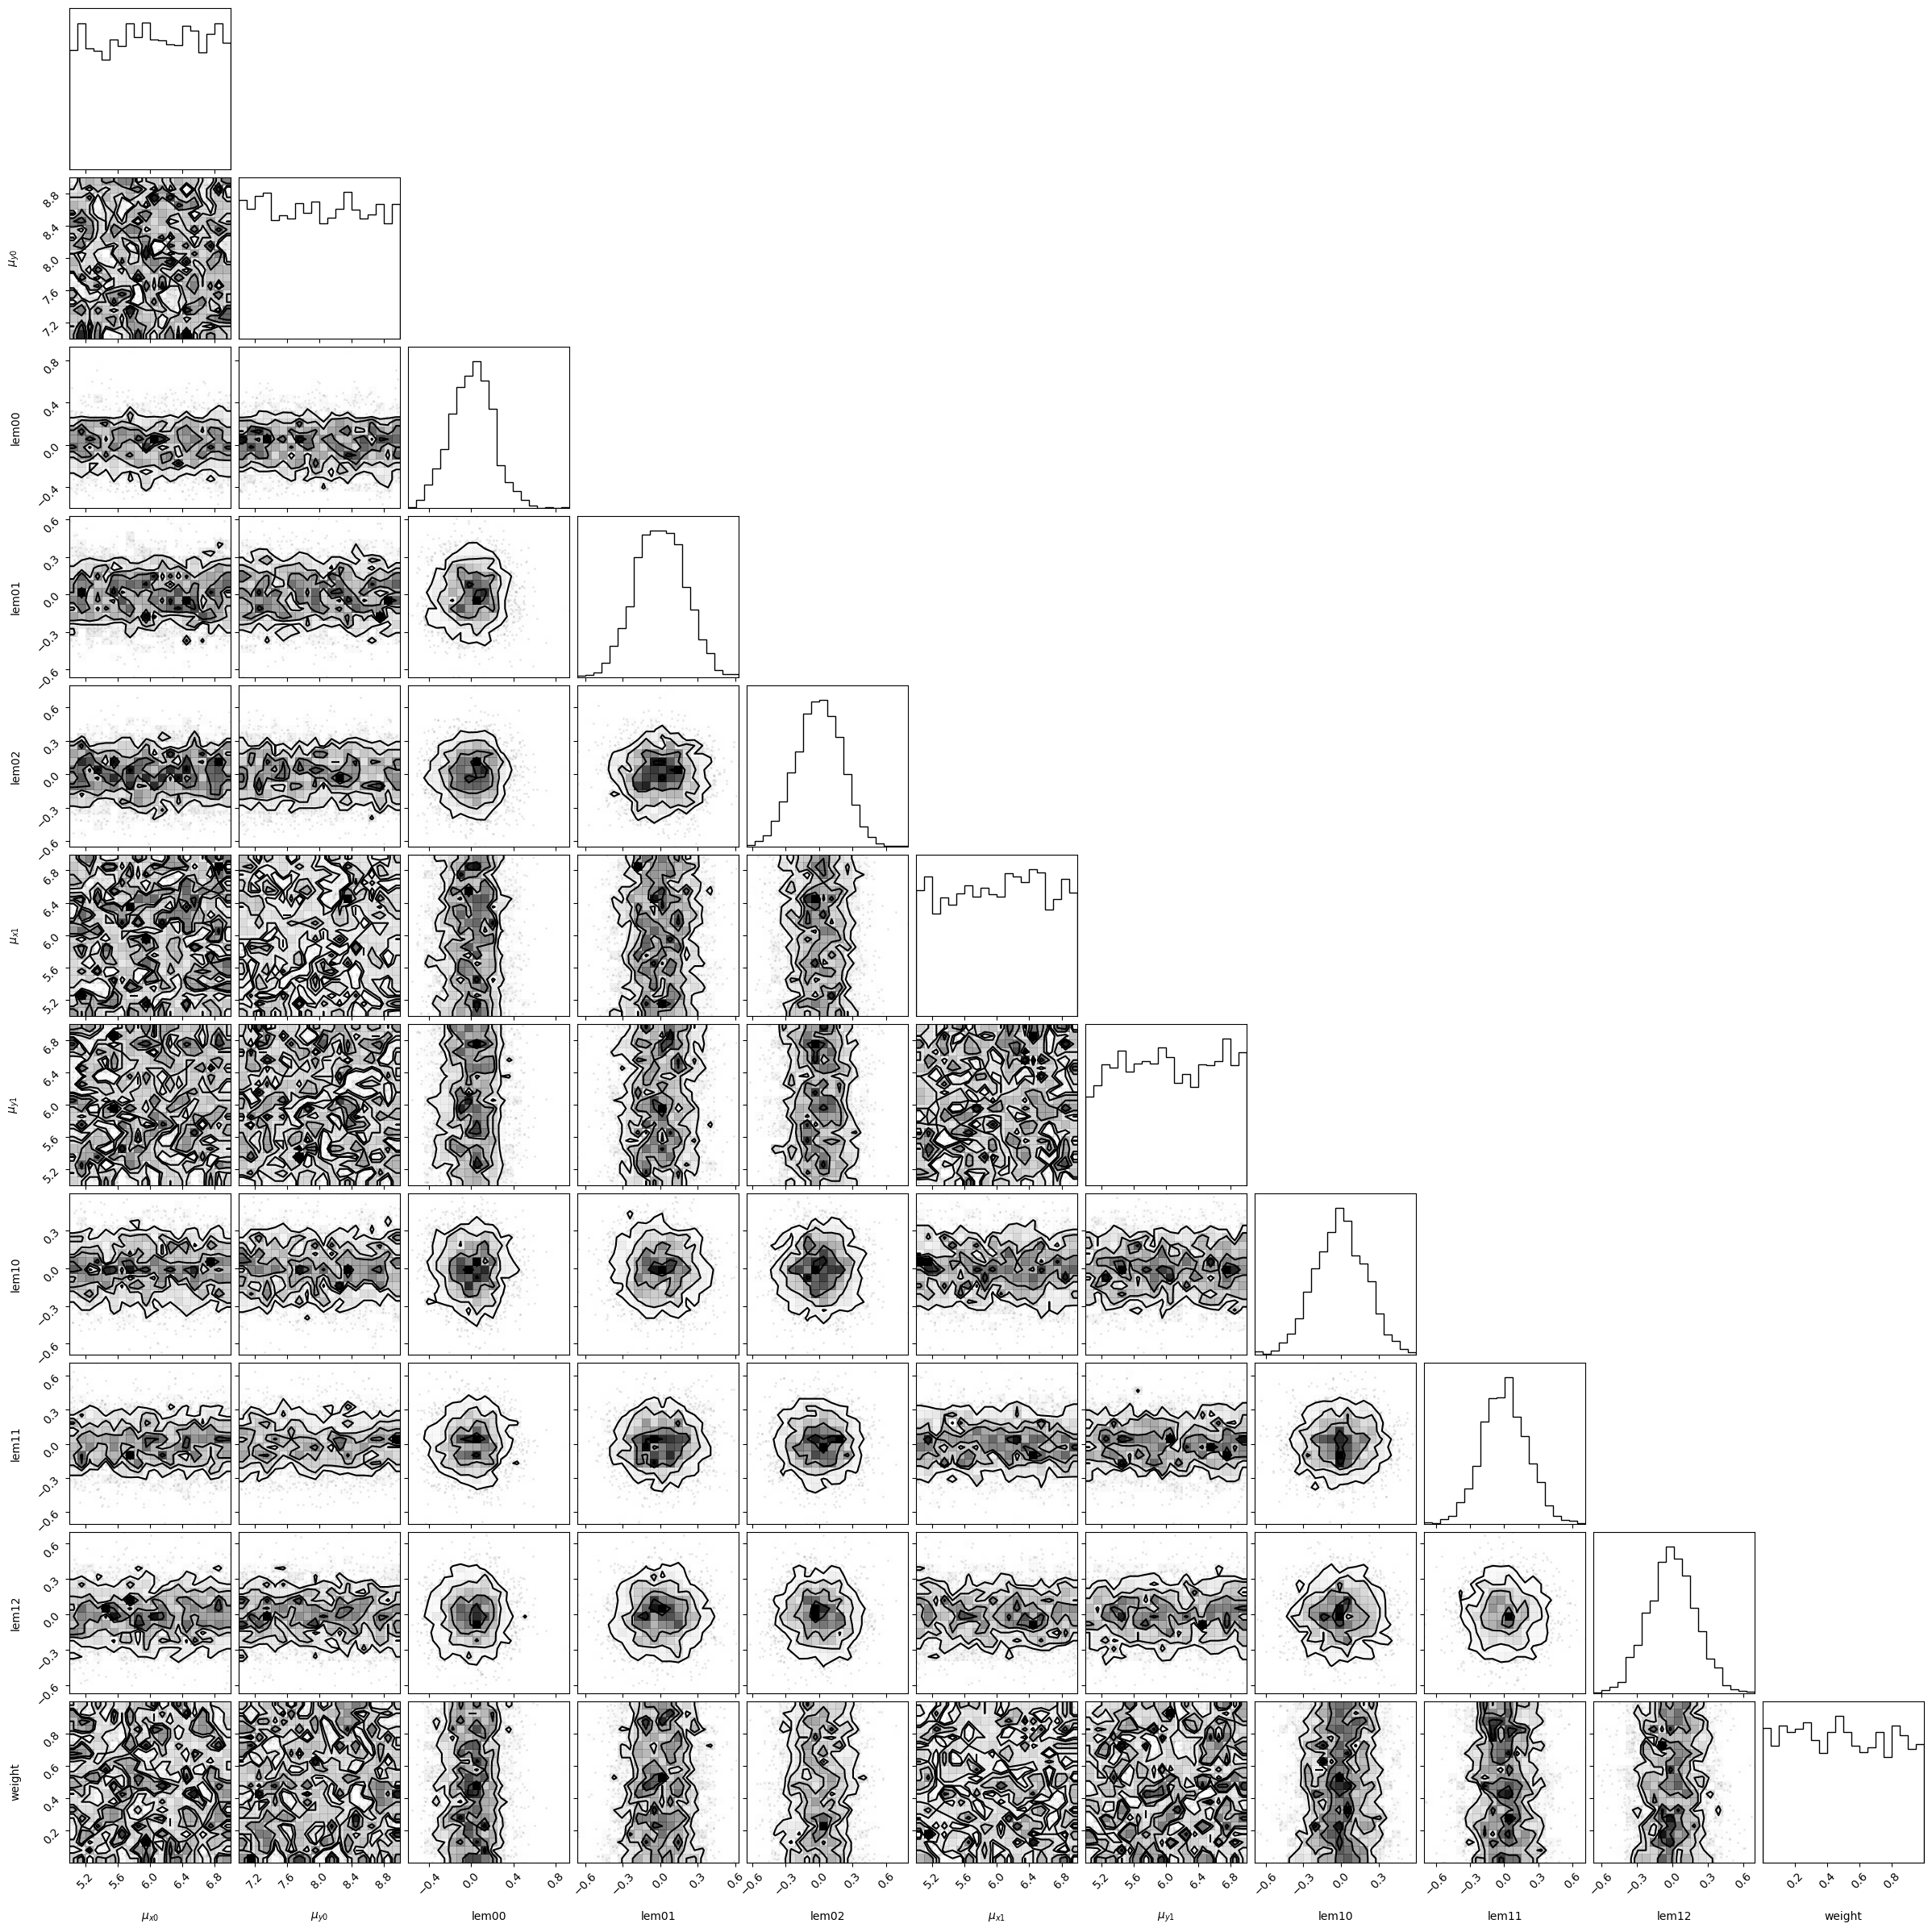

In [6]:
corner.corner(prior, labels=[r'$μ_{x0}$', r'$μ_{y0}$','lem00', 'lem01', 'lem02', 
                               r'$μ_{x1}$', r'$μ_{y1}$', 'lem10', 'lem11', 'lem12', 'weight']);

In [7]:
def data_cholesky_transfer(result):
    for p in result:
        Σ0 = CholeskyLTM(p[2:5])
        Σ1 = CholeskyLTM(p[7:10])
        var00, var01, cov0 = Σ0[0, 0], Σ0[1, 1], Σ0[0, 1]
        var10, var11, cov1 = Σ1[0, 0], Σ1[1, 1], Σ1[0, 1]
        p[2:5] = [var00, var01, cov0]
        p[7:10] = [var10, var11, cov1]

data_cholesky_transfer(prior)

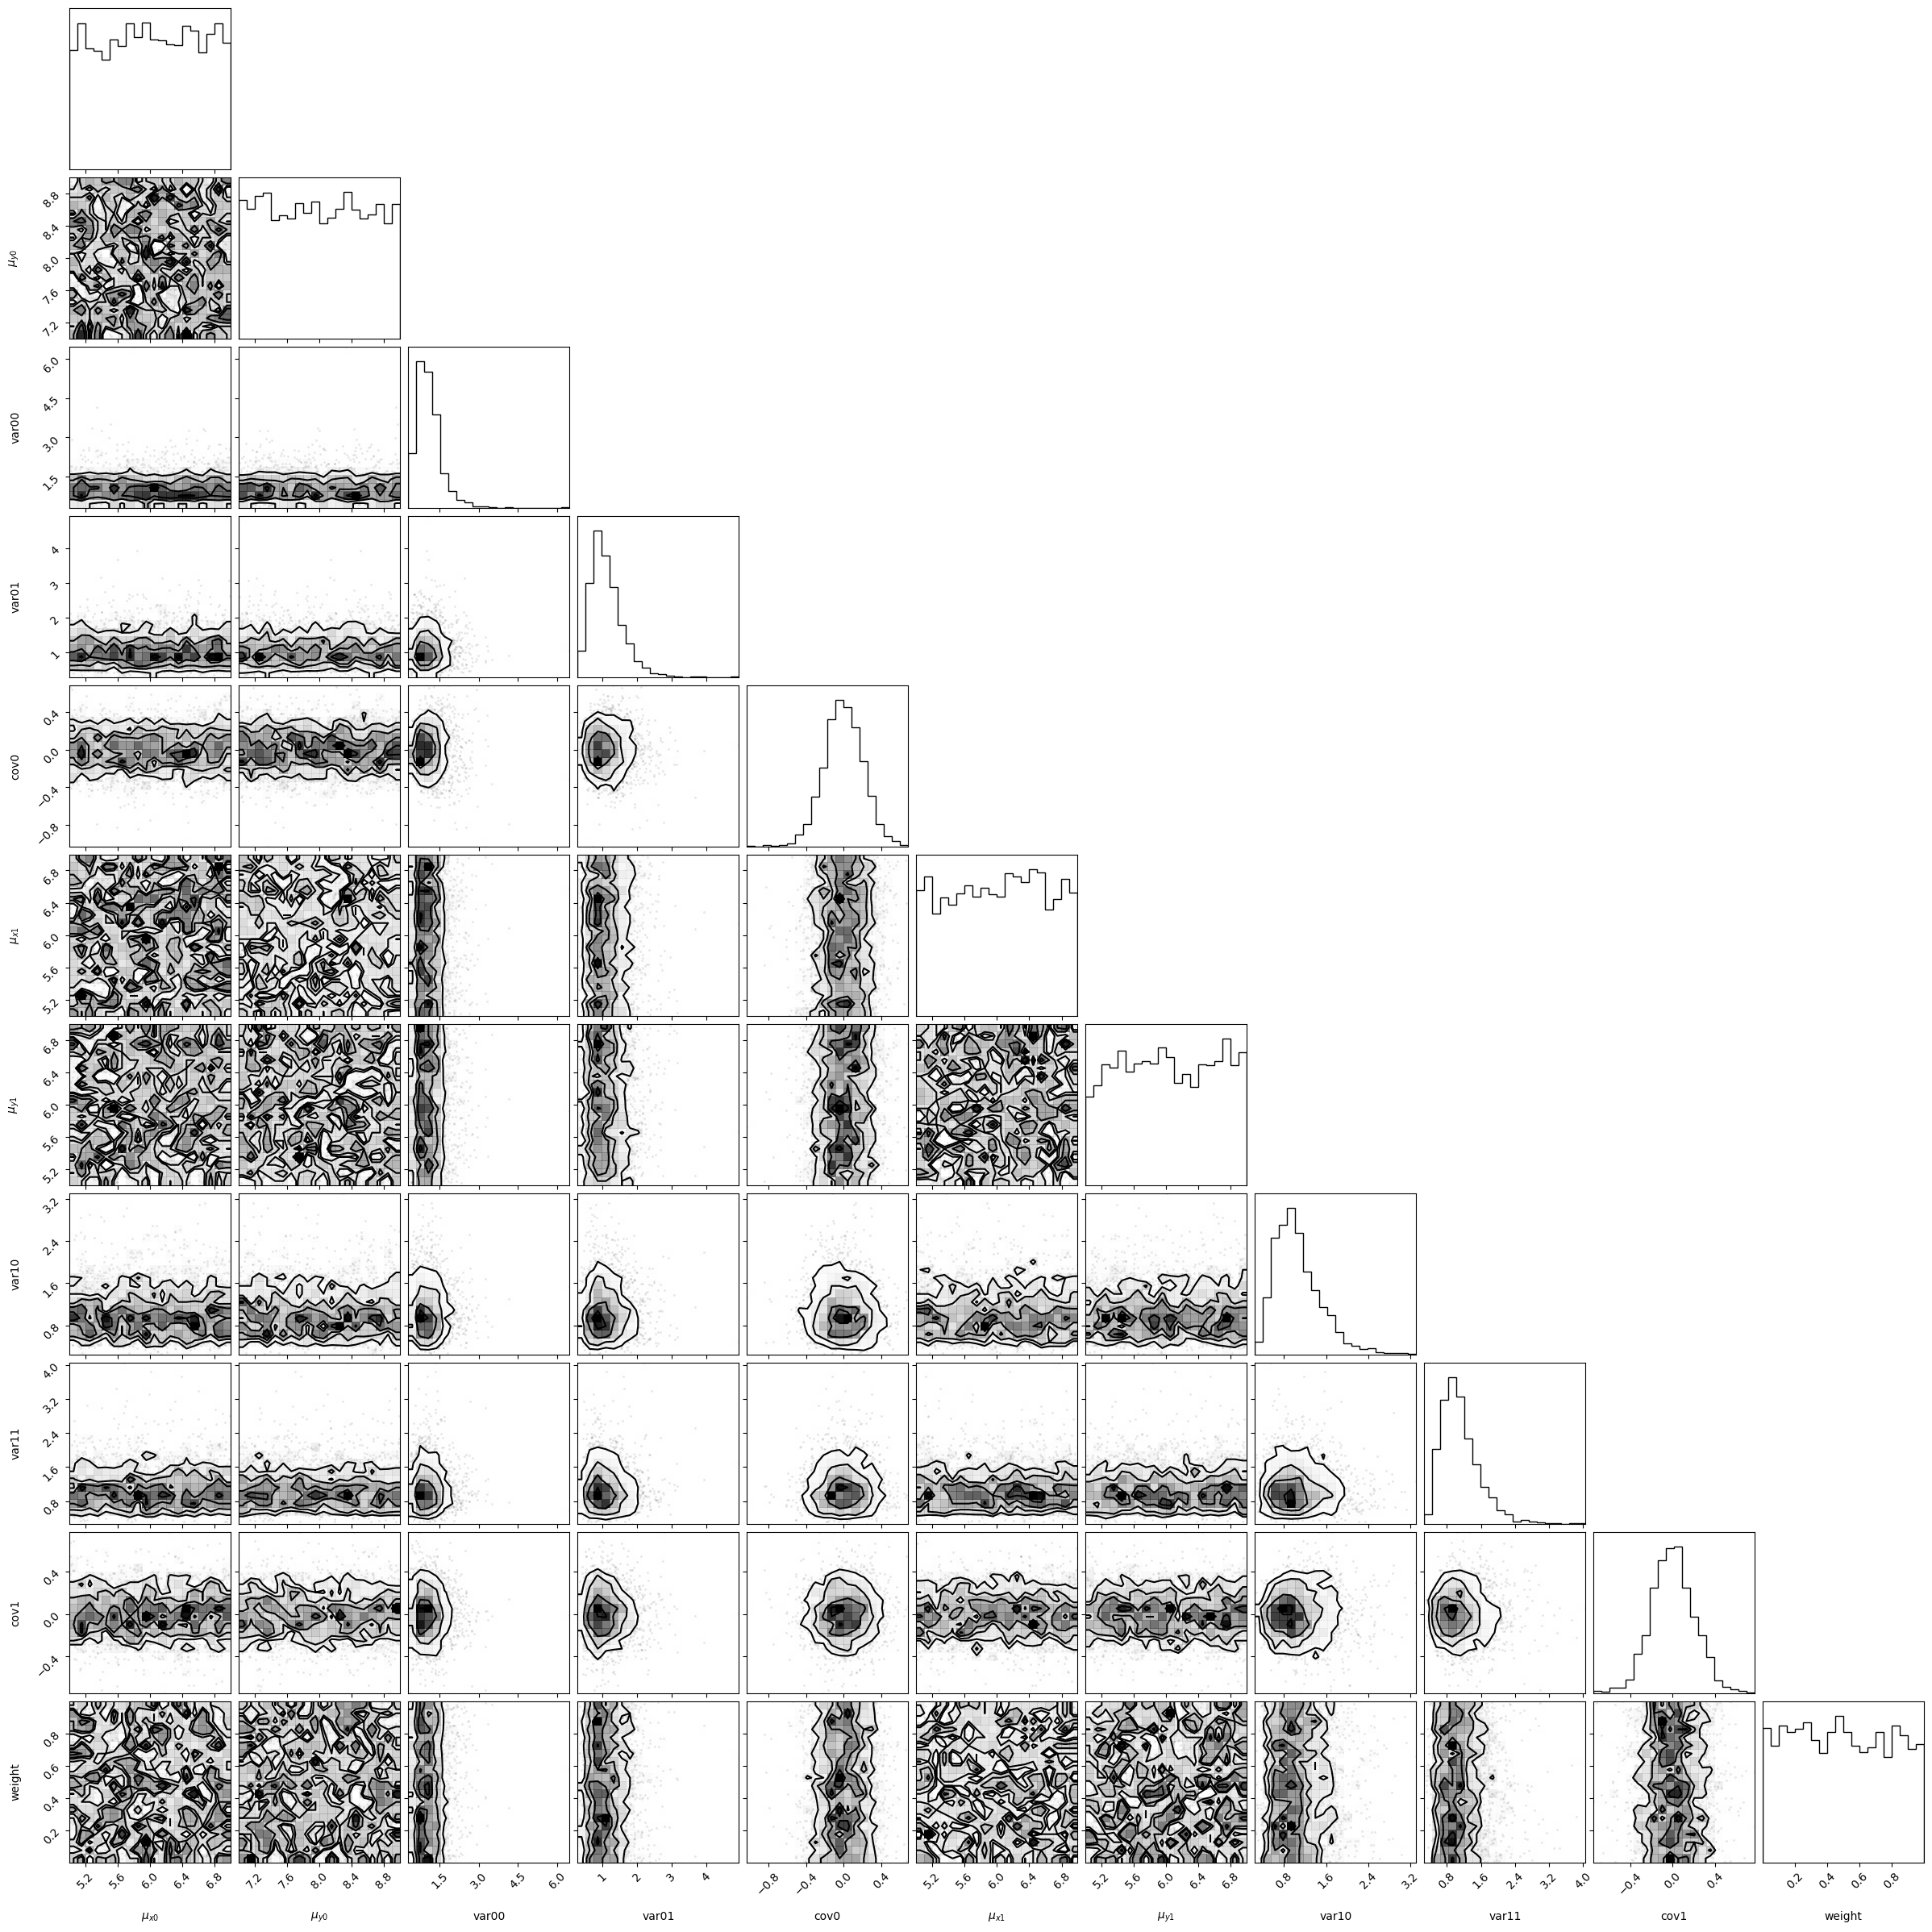

In [8]:
corner.corner(prior, labels=[r'$μ_{x0}$', r'$μ_{y0}$','var00', 'var01', 'cov0', 
                               r'$μ_{x1}$', r'$μ_{y1}$', 'var10', 'var11', 'cov1', 'weight']);

In [9]:
sampler = NestedSampler(log_likelihood, prior_transform, ndim, logl_args=[data], nlive=500)
sampler.run_nested()

z = sampler.results
results = z.samples_equal()

26777it [11:46, 37.92it/s, +500 | bound: 336 | nc: 1 | ncall: 792422 | eff(%):  3.444 | loglstar:   -inf < -1664.906 <    inf | logz: -1717.863 +/-  0.332 | dlogz:  0.001 >  0.509]


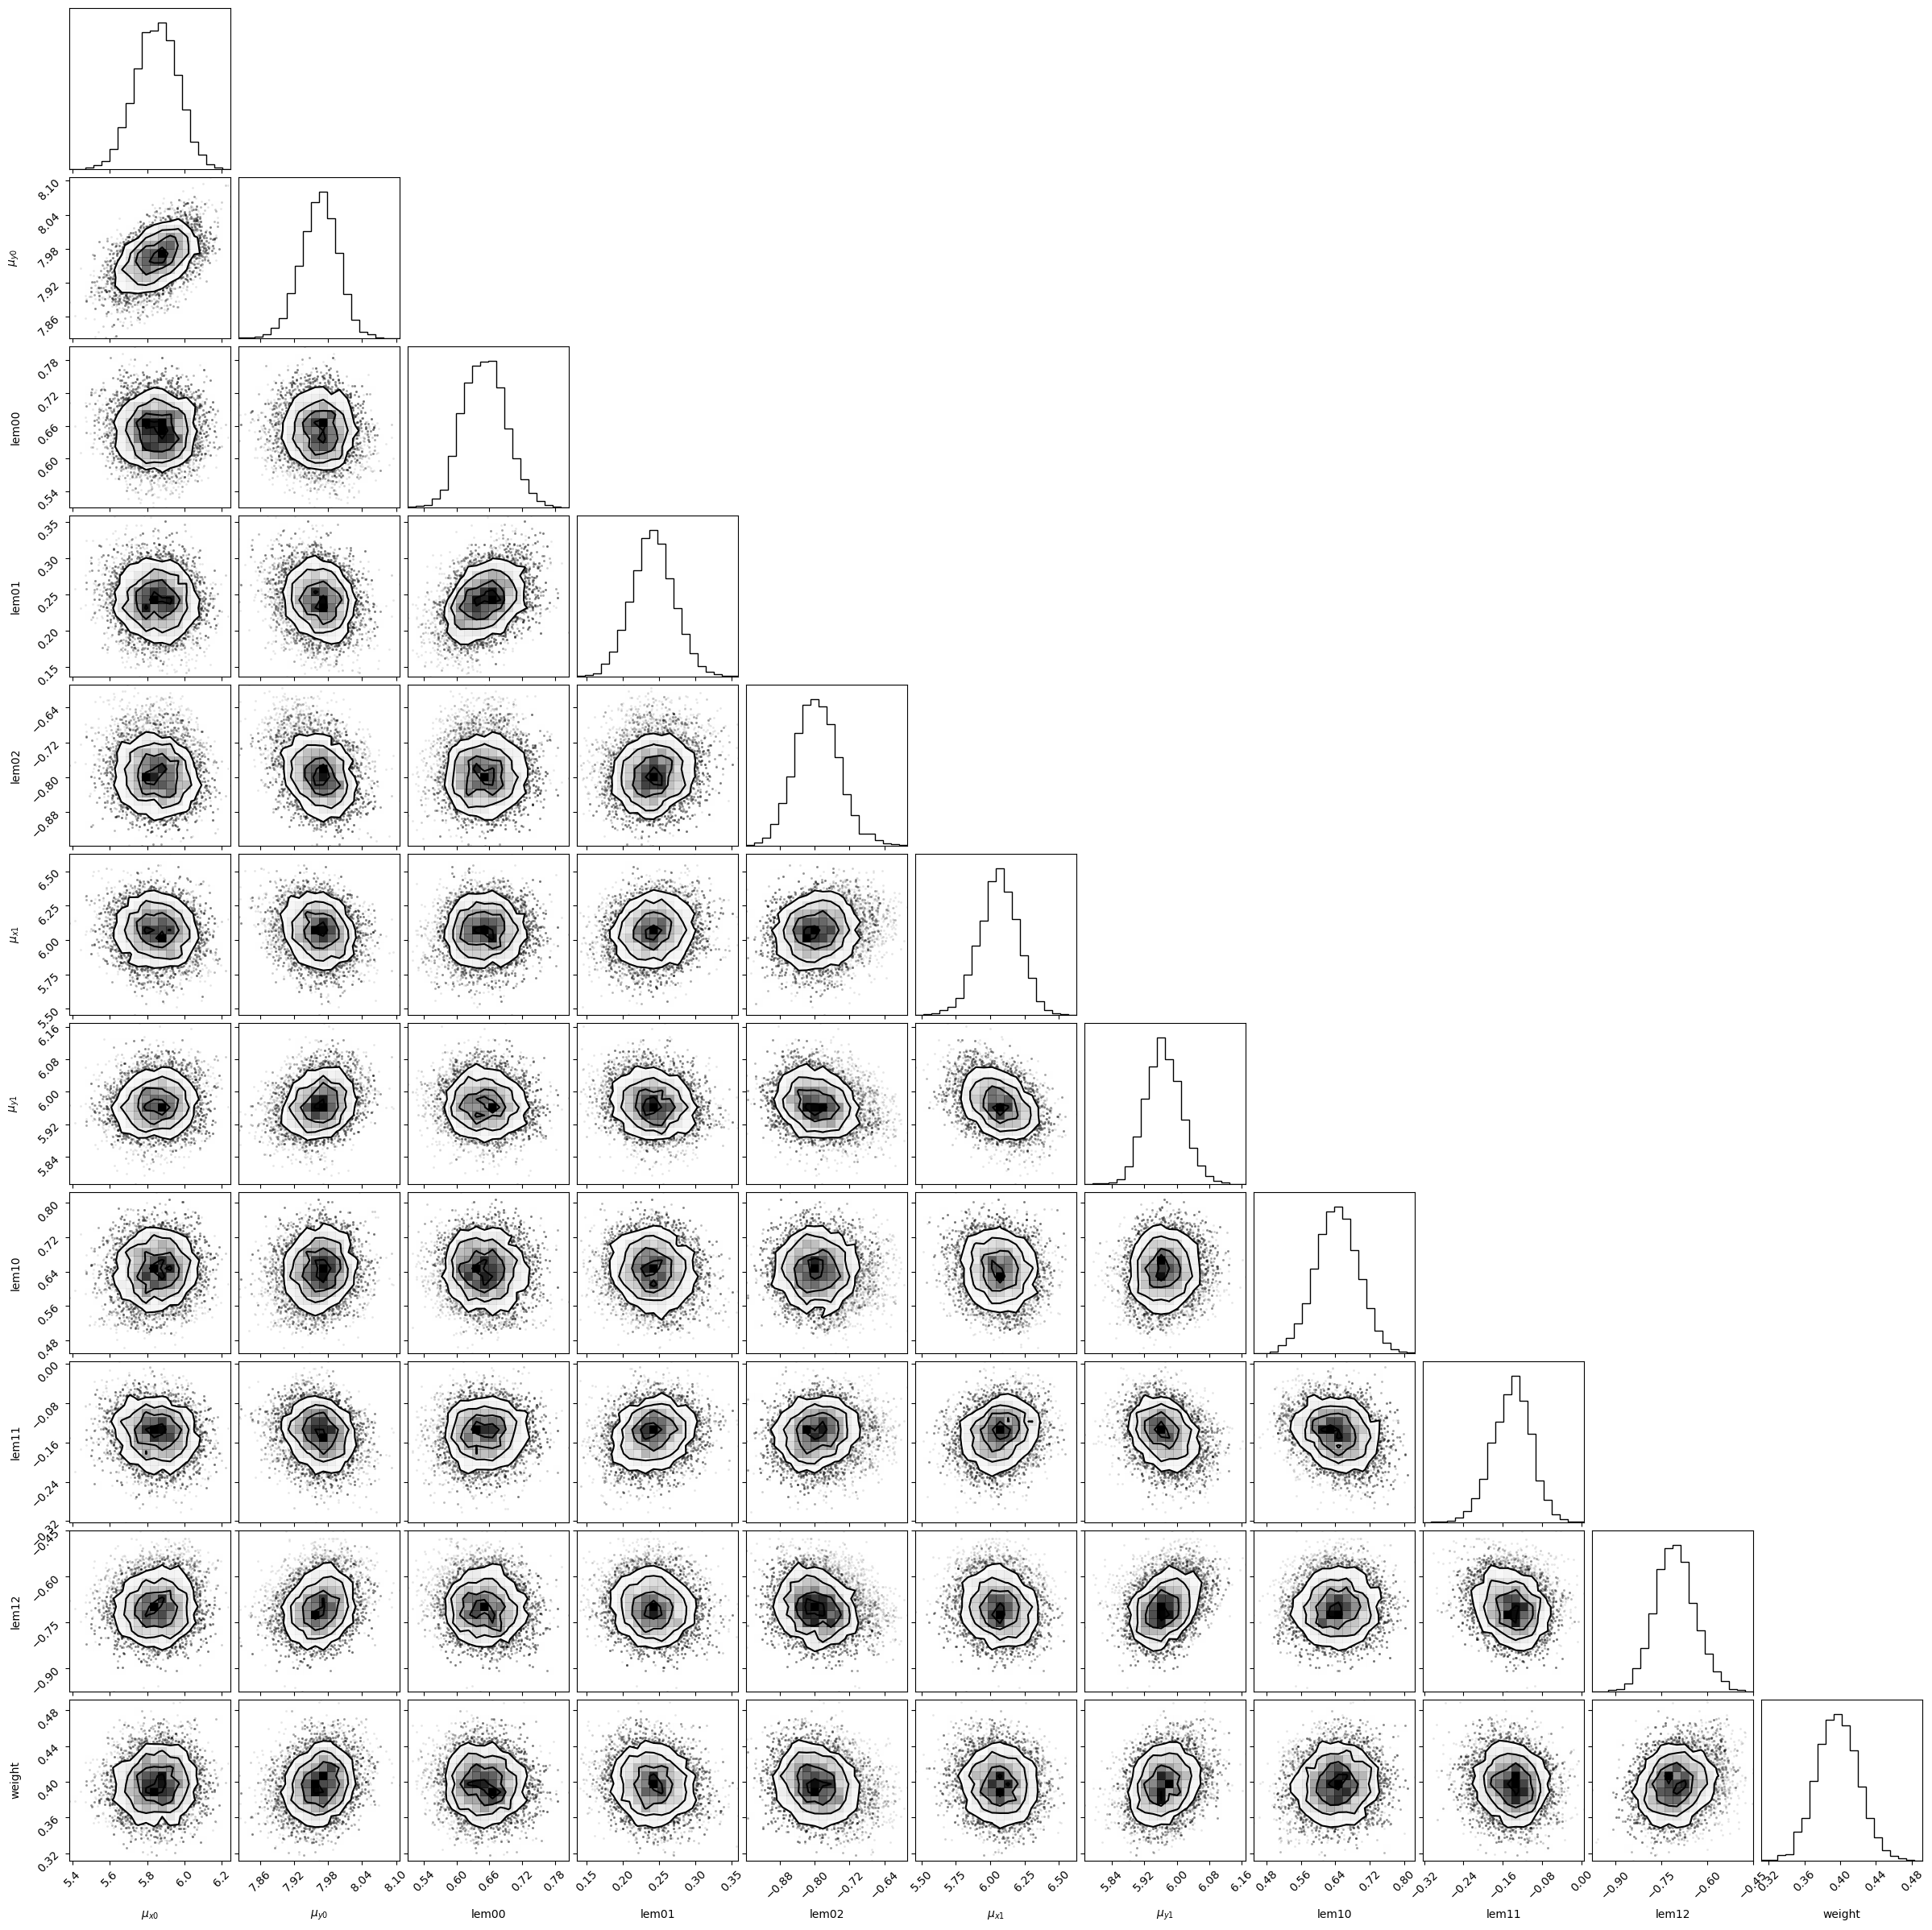

In [10]:
corner.corner(results, labels=[r'$μ_{x0}$', r'$μ_{y0}$','lem00', 'lem01', 'lem02', 
                               r'$μ_{x1}$', r'$μ_{y1}$', 'lem10', 'lem11', 'lem12', 'weight']);

In [11]:
data_cholesky_transfer(results)

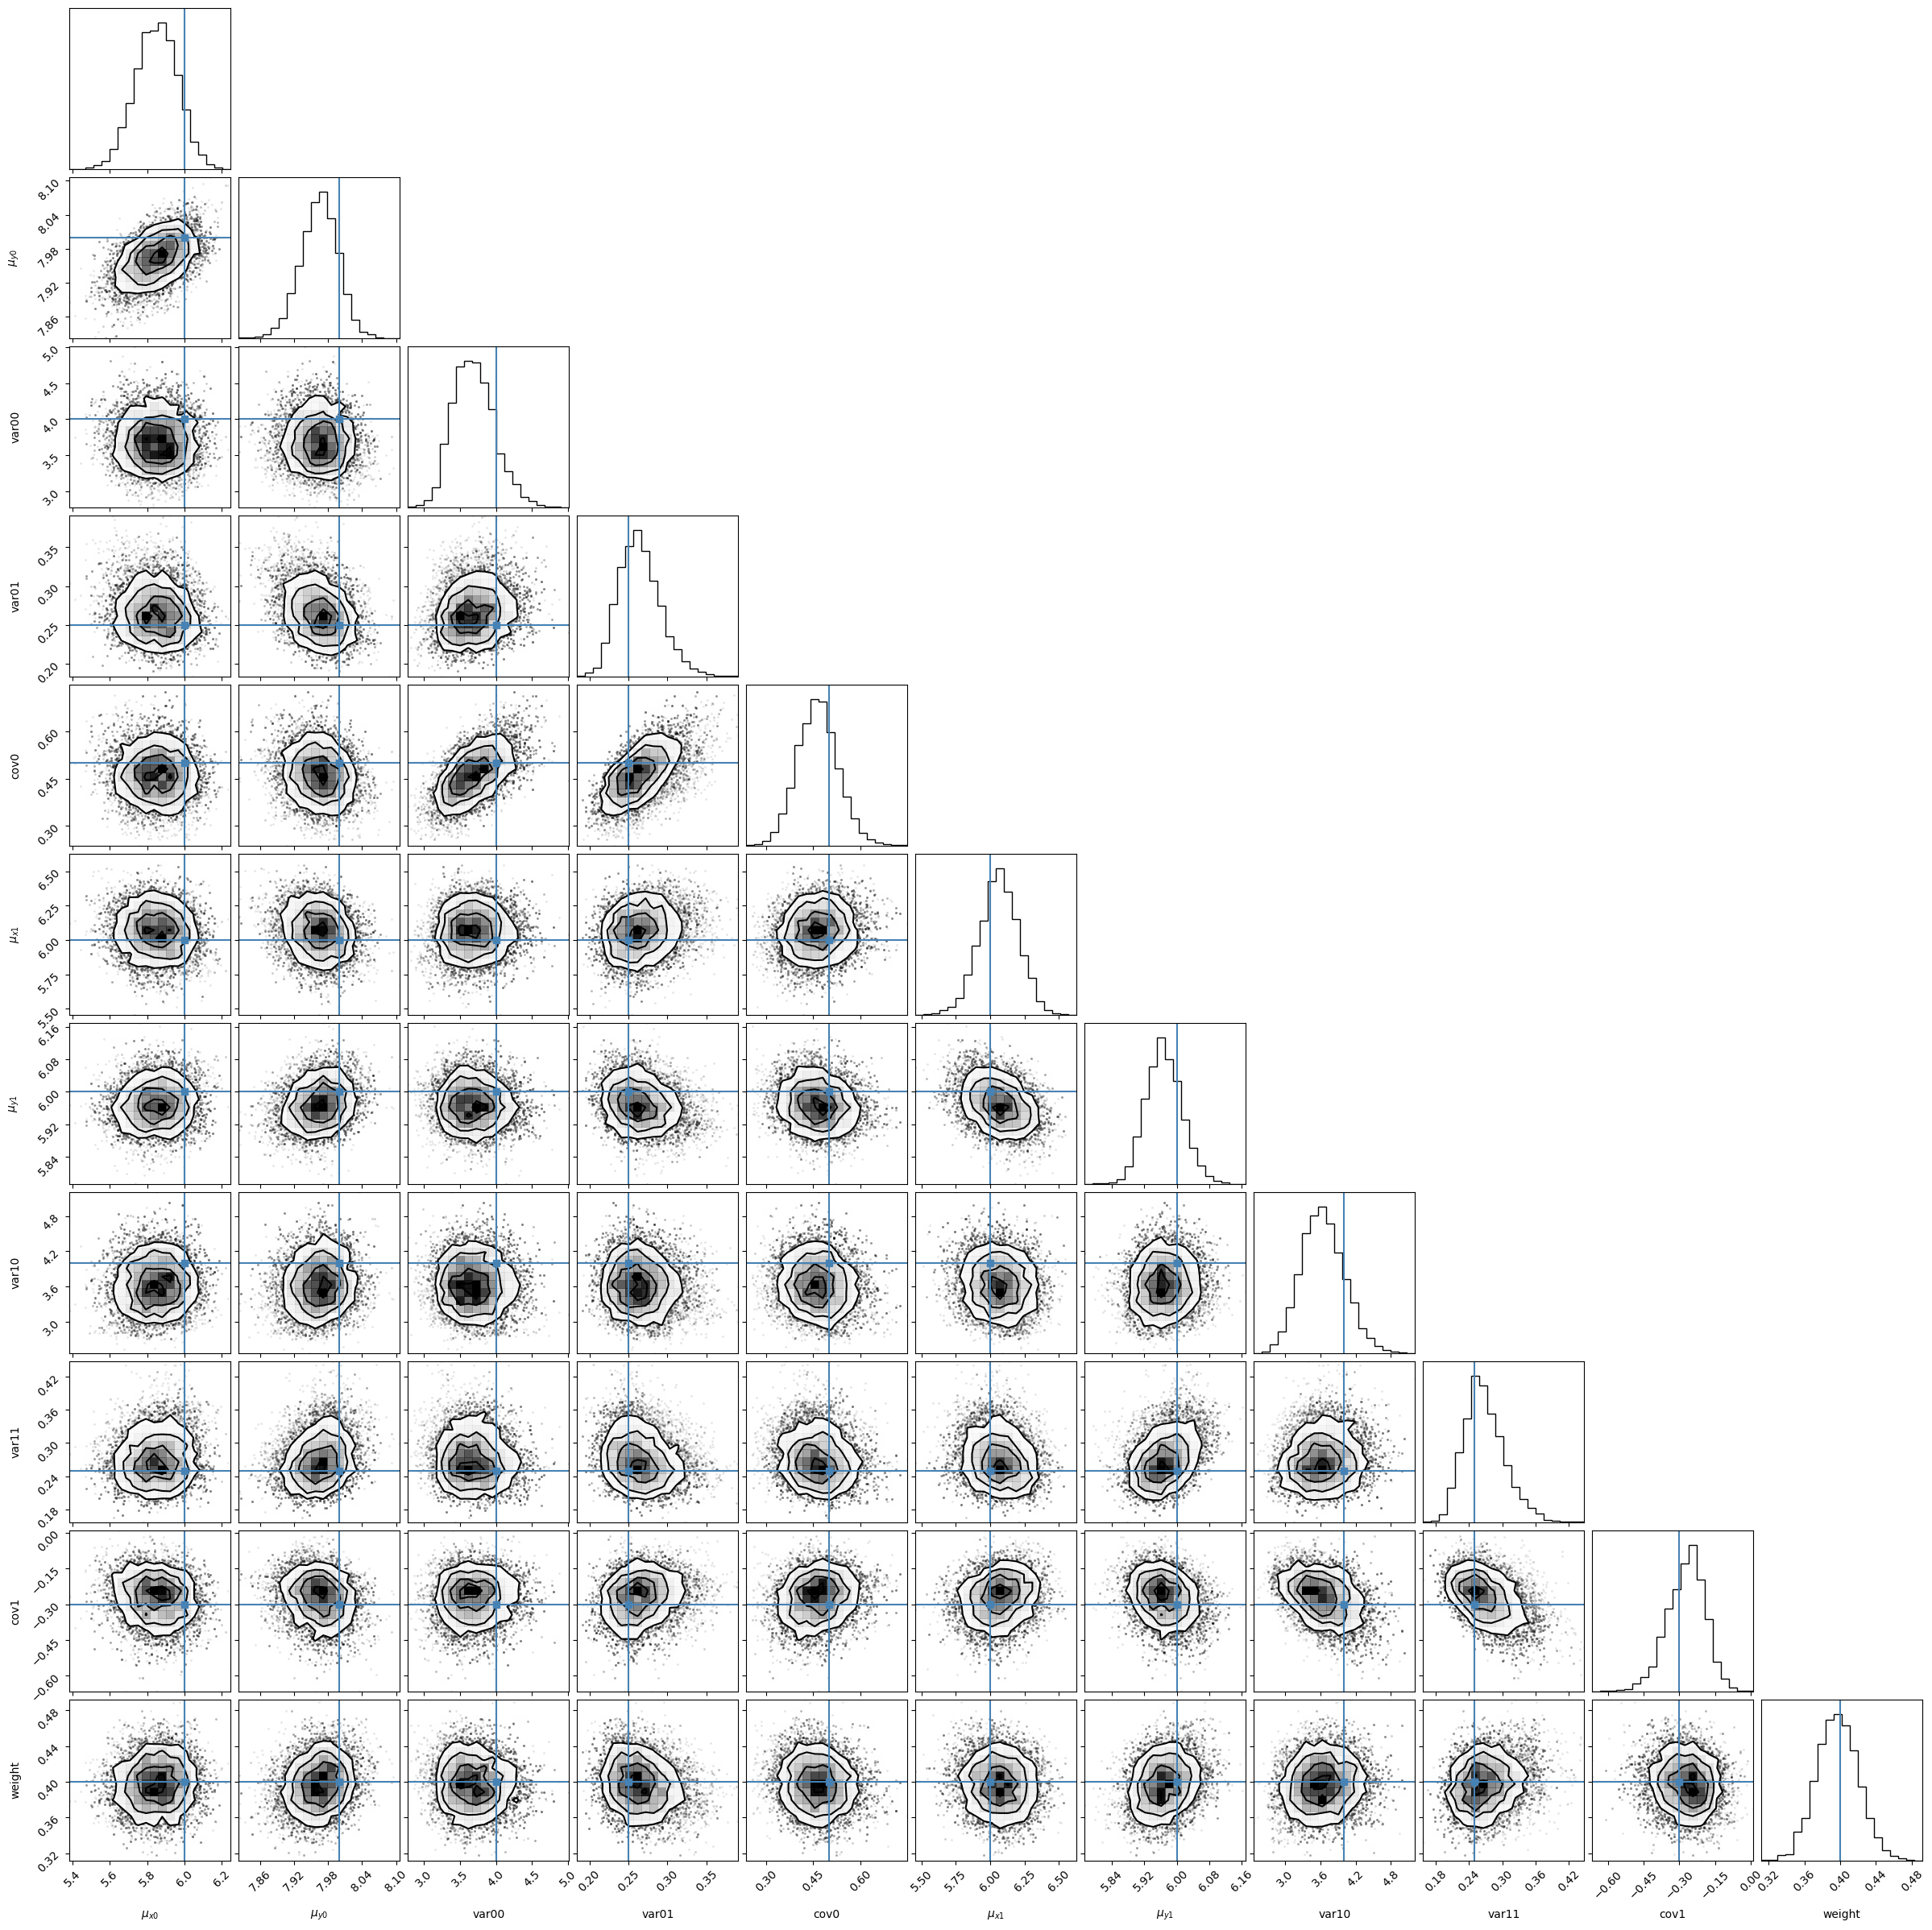

In [12]:
corner.corner(results, labels=[r'$μ_{x0}$', r'$μ_{y0}$','var00', 'var01', 'cov0', 
                               r'$μ_{x1}$', r'$μ_{y1}$', 'var10', 'var11', 'cov1', 'weight'],
             truths=[μ0[0], μ0[1], Σ0[0, 0], Σ0[1, 1], Σ0[0, 1], μ1[0], μ1[1], Σ1[0, 0], Σ1[1, 1], Σ1[0, 1], weight]);